In [1]:
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler, NearMiss #, TomekLinks, EditedNearestNeighbours
from imblearn.over_sampling import BorderlineSMOTE, ADASYN
# from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV # , RandomizedSearchCV
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,  roc_curve, roc_auc_score
from sklearn.ensemble import BaggingClassifier
# from sklearn.compose import make_column_selector




In [2]:
stroke = pd.read_csv("../../00-data/healthcare-dataset-stroke-data.csv")

stroke


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
X = stroke.drop(['stroke', 'id'], axis=1)

y = stroke['stroke'].values

In [4]:
X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked
...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked


In [5]:
y

array([1, 1, 1, ..., 0, 0, 0], shape=(5110,))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [7]:
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

numerical_transformer = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = ImbPipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_with_imputation = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [8]:
X.shape

(5110, 10)

In [9]:
bagging_nn = BaggingClassifier(
    estimator=3,
    n_estimators=10,
    random_state=0,
    n_jobs=-1
)

In [10]:
# numerical_features = X.select_dtypes(include=np.number).columns
# categorical_features = X.select_dtypes(include='object').columns

# numerical_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)
#     ])

In [11]:
# base_estimator = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', MLPClassifier(max_iter=1000, random_state=0))
# ])

In [12]:
pipeline = ImbPipeline([
    ('preprocessor', preprocessor_with_imputation),
    ('undersampler', NearMiss()),
    ('oversampler', BorderlineSMOTE(random_state=0)),
    # ('pca', PCA(random_state=0)),
    ('nn_classifier', MLPClassifier(max_iter=1000, early_stopping=True, n_iter_no_change=20, random_state=0)),
    # ('classifier', bagging_nn)
])

# pipeline = ImbPipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('oversampler', BorderlineSMOTE(random_state=0)),
#     # Se vuoi usare anche l'undersampling, lo inserisci qui
#     # ('undersampler', NearMiss()),
#     ('nn_classifier', MLPClassifier(max_iter=1000, early_stopping=True, n_iter_no_change=20, random_state=0)),
#     # ('bagging_classifier', BaggingClassifier(base_estimator=base_estimator, n_estimators=10, random_state=0))
# ])

voglio una metrica che dia piu peso ai veri positivi considerando però anche i veri negativi

In [13]:
def custom_weighted_scorer(estimator, X, y_true):
    y_pred = estimator.predict(X)
    cm = confusion_matrix(y_true, y_pred)

    tp = cm[1, 1]
    fn = cm[1, 0]
    fp = cm[0, 1]
    tn = cm[0, 0]

    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Pesi: recall molto alto, specificity alto, penalità forti per FN e FP
    weighted_score = (
        0.8 * recall +           # Altissimo peso ai veri positivi
        0.7 * specificity -     # Peso importante ai veri negativi
        0.4 * (fn / (tp + fn) if (tp + fn) > 0 else 0.0) -  # Penalità fortissima per FN
        0.1 * (fp / (tn + fp) if (tn + fp) > 0 else 0.0)    # Penalità moderata per FP
    )
    return weighted_score


{'nn_classifier__activation': 'tanh',
 'nn_classifier__alpha': 0.2,
 'nn_classifier__hidden_layer_sizes': (80, 40, 20, 10),
 'nn_classifier__learning_rate_init': 0.0003,
 'nn_classifier__n_iter_no_change': 50,
 'nn_classifier__solver': 'sgd',
 'oversampler': ADASYN(random_state=0),
 'oversampler__n_neighbors': 4,
 'oversampler__sampling_strategy': 'auto',
 'undersampler': RandomUnderSampler(random_state=0),
 'undersampler__sampling_strategy': 0.15}

In [14]:
param_distributions = [
    {
        'undersampler': [RandomUnderSampler(random_state=0), NearMiss()],
        'undersampler__sampling_strategy': [0.15],
        'oversampler': [ADASYN(random_state=0)], #  BorderlineSMOTE(random_state=0)
        'oversampler__sampling_strategy': ['auto'],
        'oversampler__n_neighbors': [4],
        # 'pca__n_components': [None, 10],
        'nn_classifier__hidden_layer_sizes': [(80,40,20,10)],
        'nn_classifier__activation': ['tanh'],
        'nn_classifier__alpha': [0.2],
        'nn_classifier__learning_rate_init': [0.0003],
        'nn_classifier__solver': ['sgd'],
        'nn_classifier__n_iter_no_change': [50]
    }
]

In [15]:
# n_iter=500, random_state=0

random_search = GridSearchCV(pipeline, param_distributions,  cv=5, scoring=custom_weighted_scorer, verbose=2, n_jobs=-1)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['gender...
                          'nn_classifier__n_iter_no_change': [50],
                          'nn_classifier__solver': ['sgd'],
                          'oversampler': [ADASYN(random_state=0)],
                          'oversampler__n_neighbors': [4],
                          'oversampler__sampling_strategy': ['auto'],
                          'undersampler': [RandomUnderSampler(random_state=0),
                                           NearMiss()],
                          'undersampler__sampling_strategy': [0.15]}],
             scoring=<function custom_weighted_scorer at 0x000001EC73C4EDE0>,
             verbose=2)

In [16]:
random_search.best_params_

{'nn_classifier__activation': 'tanh',
 'nn_classifier__alpha': 0.2,
 'nn_classifier__hidden_layer_sizes': (80, 40, 20, 10),
 'nn_classifier__learning_rate_init': 0.0003,
 'nn_classifier__n_iter_no_change': 50,
 'nn_classifier__solver': 'sgd',
 'oversampler': ADASYN(random_state=0),
 'oversampler__n_neighbors': 4,
 'oversampler__sampling_strategy': 'auto',
 'undersampler': RandomUnderSampler(random_state=0),
 'undersampler__sampling_strategy': 0.15}

In [17]:
random_search.best_score_

np.float64(1.0893979935586569)

In [18]:
def create_confusion_matrix (model, X, y):
  
  # best_model = model.best_estimator_
  
  y_pred = model.predict(X)

  class_names = ['Classe 0 (Nessun ictus)', 'Classe 1 (Ictus)']
  print("\n--- Confusion Matrix ---")
  cm = confusion_matrix(y, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.show()

  print(classification_report(y, y_pred, target_names=class_names))
  print(cm)
  
  fpr, tpr, thresholds = roc_curve(y, y_pred)
  auc = roc_auc_score(y, y_pred)
  
  plt.figure()
  plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve - SVM')
  plt.legend(loc='lower right')
  plt.show()

In [19]:
model = random_search.best_estimator_

# bagging_model = BaggingClassifier(
#     estimator=best_pipeline,
#     n_estimators=10,
#     random_state=0,
#     n_jobs=-1
# )

# bagging_model.fit(X_train, y_train)



--- Confusion Matrix ---


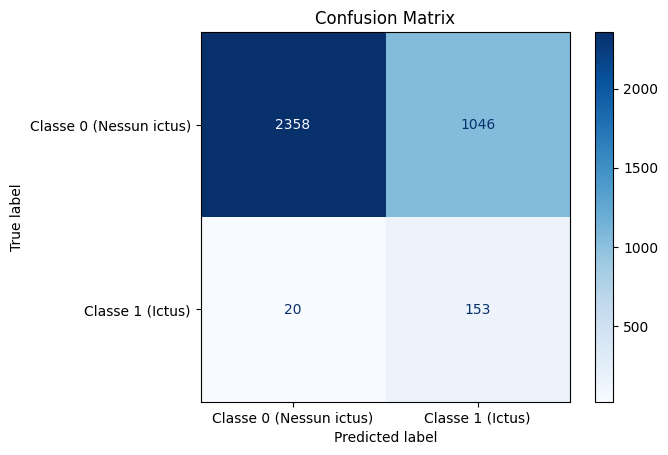

                         precision    recall  f1-score   support

Classe 0 (Nessun ictus)       0.99      0.69      0.82      3404
       Classe 1 (Ictus)       0.13      0.88      0.22       173

               accuracy                           0.70      3577
              macro avg       0.56      0.79      0.52      3577
           weighted avg       0.95      0.70      0.79      3577

[[2358 1046]
 [  20  153]]


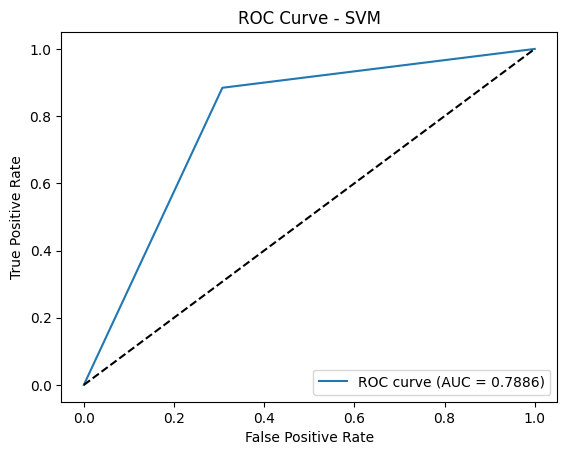

In [20]:
# bagging_model
create_confusion_matrix(model, X_train, y_train)


--- Confusion Matrix ---


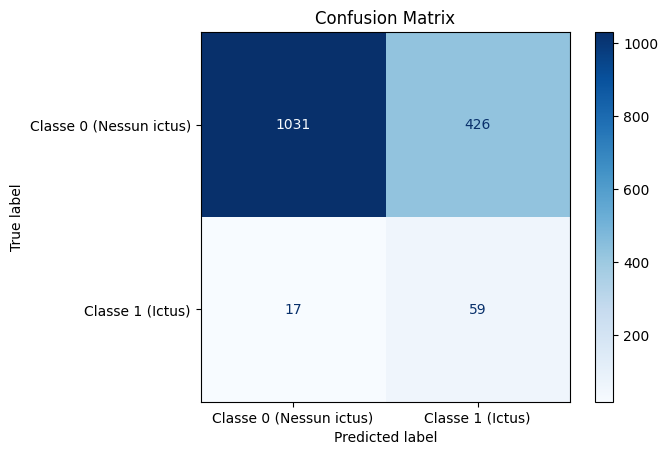

                         precision    recall  f1-score   support

Classe 0 (Nessun ictus)       0.98      0.71      0.82      1457
       Classe 1 (Ictus)       0.12      0.78      0.21        76

               accuracy                           0.71      1533
              macro avg       0.55      0.74      0.52      1533
           weighted avg       0.94      0.71      0.79      1533

[[1031  426]
 [  17   59]]


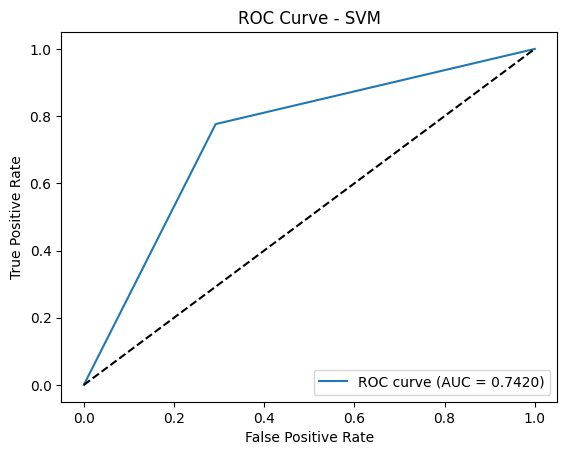

In [21]:
create_confusion_matrix(model, X_test, y_test)